In [1]:
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
# uses the CAMB cosmology which produced the cls
import camb
from cosmology import Cosmology
import glass
import glass.ext.camb
from astropy.constants import M_sun

In [2]:
nside=256
freqs=np.arange(544,1088,step=10) #instead of steps of1MHz use 10
nfreqs=len(freqs)
lmax=3*nside -1

# # creating a numpy random number generator for sampling
# rng = np.random.default_rng(seed=42)

# cosmology for the simulation
h = 1.0
Oc = 0.25
Ob = 0.05
rho_HI= 5.46e7 #h_70 M_sun Mpc^-3
print(rho_HI)
# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=70 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

54600000.0


In [3]:
freqs[0]

np.int64(544)

In [4]:
z_f= (1420/544)-1
z_i= (1420/1087)-1
# set up the redshift range
# z = np.linspace(z_i, z_f, nfreqs)
print(z_i, z_f)

0.30634774609015647 1.6102941176470589


In [168]:
def compute_matter_cls(z_i:float, z_f: float, nfreq: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB without correlations between shells.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreq)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)
    
    cl_diag = np.zeros((nfreqs, nfreqs, lmax + 1))

    for i in range(nfreqs-1):
        # Compute angular power spectrum from just one shell
        print ("processing spectra %d" % i)
        cls_i = glass.ext.camb.matter_cls(pars, lmax, [shells[i]])
        cl_diag[i, i,:] = cls_i[0]  # This is Cl^i
    
    return shells, cl_diag

In [162]:
def compute_matter_cls_full(z_i: float, z_f: float, nfreq: int, lmax: int):
    """
    Compute full matter angular power spectra C_ell^{ij} using GLASS/CAMB.

    Parameters:
    - z_i: Initial redshift.
    - z_f: Final redshift.
    - nfreq: Number of frequency shells.
    - lmax: Maximum multipole.

    Returns:
    - shells: list of window functions.
    - cls_full: array of shape (lmax+1, nfreq, nfreq) with all C_ell^{ij}.
    """
    zb = glass.redshift_grid(z_i, z_f, num=nfreq)
    shells = glass.linear_windows(zb, dz=0.1 * (z_f - z_i) / nfreq)

    cls_full = np.zeros((lmax + 1, nfreq, nfreq))

    for i in range(nfreq-1):
        for j in range(i, nfreq-1):  # Only compute upper triangle (symmetric)
            print(f"Computing C_ell^{{{i},{j}}}")
            cls_ij = glass.ext.camb.matter_cls(pars, lmax, [shells[i], shells[j]])
            cls_full[:, i, j] = cls_ij[0]  # C_ell^{ij}
            if i != j:
                cls_full[:, j, i] = cls_ij[0]  # Symmetry: C_ell^{ji} = C_ell^{ij}

    return shells, cls_full

In [71]:
def compute_matter_cls_corr(z_i:float, z_f: float, nfreq: int, lmax:int):
    """
    Compute the matter angular power spectrum using CAMB with correlations between shells.
    
    Parameters:
    z_i (float): Initial redshift.
    z_f (float): Final redshift.
    nfreqs (int): Number of frequency channels.
    lmax (int): Maximum multipole.
    
    Returns:
    cls: Angular power spectrum
    """
    zb=glass.redshift_grid(z_i, z_f, num=nfreq)

    # triangular radial windows, equivalent to linear interpolation of n(z)
    shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)
    
    # compute angular matter power spectra with CAMB
    cls = glass.ext.camb.matter_cls(pars, lmax, shells)
    
    return shells, cls

In [169]:
shells_i, cls_hi=compute_matter_cls(z_i,z_f, nfreqs, lmax)
print(len(cls_hi))

/tmp/ipykernel_329796/3660055063.py:17: UserWarning: first triangular window does not start at z=0
  shells = glass.linear_windows(zb, dz=0.1*(z_f-z_i)/nfreq)


processing spectra 0
processing spectra 1
processing spectra 2
processing spectra 3
processing spectra 4
processing spectra 5
processing spectra 6
processing spectra 7
processing spectra 8
processing spectra 9
processing spectra 10
processing spectra 11
processing spectra 12
processing spectra 13
processing spectra 14
processing spectra 15
processing spectra 16
processing spectra 17
processing spectra 18
processing spectra 19
processing spectra 20
processing spectra 21
processing spectra 22
processing spectra 23
processing spectra 24
processing spectra 25
processing spectra 26
processing spectra 27
processing spectra 28
processing spectra 29
processing spectra 30
processing spectra 31
processing spectra 32
processing spectra 33
processing spectra 34
processing spectra 35
processing spectra 36
processing spectra 37
processing spectra 38
processing spectra 39
processing spectra 40
processing spectra 41
processing spectra 42
processing spectra 43
processing spectra 44
processing spectra 4

In [73]:
cls_healpix=glass.glass_to_healpix_spectra(cls_hi)

In [74]:
idx= glass.spectra_indices(len(shells_i))
x,y=idx[5]
print(x)
print(y)
print(len(idx))

2
0
1485


In [75]:
# Initialize the array to store the full spectra
cls_full = np.zeros((nfreqs, nfreqs, lmax + 1))

# Loop over index pairs (i, j)
for pair in idx:
    i, j = pair  # unpack the pair
    cl_ij = glass.getcl(cls_healpix, i, j)  # get the C_l^{ij} spectrum
    cls_full[i, j, :] = cl_ij
    if i != j:
        cls_full[j, i, :] = cl_ij  # fill the symmetric entry

print(cls_full.shape) #C_l{ij} in GLASS ordering

(55, 55, 768)


In [102]:
def diagonalize_matrices(cl, nfreqs):
    cl_diag=np.zeros((nfreqs, nfreqs, lmax))
    for l in range (lmax):
        #print(f"Diagonalizing matrix {l}")
        cl_diag[:,:,l]= np.identity(nfreqs)*cl[:,:,l]
    return cl_diag
hi_d= diagonalize_matrices(cls_full, nfreqs)

In [174]:
cls_hi.shape

(55, 55, 768)

In [170]:
cov=glass.cov_from_spectra(cls_hi,lmax=lmax)
print(cov.shape)

(768, 10, 10)


In [ ]:
# Cl_hi=np.zeros_like(cls_hi)
# for i in range(nfreqs-1):
#     Cl_hi[i]= cls_hi[i, :]*rho_HI**2
#     # Cl_hi[i]= cls_hi[i, :]

In [171]:
def redshift_from_freq(freq_MHz):
    """Convert frequency in MHz to redshift."""
    nu_21 = 1420.40575  # MHz
    return (nu_21 / freq_MHz) - 1
from astropy.cosmology import Planck15 as cosmo

def T_bar(z, Omega_HI=4.02e-4, h=1.0):
    """Compute mean 21cm brightness temperature in mK."""
    H_z = cosmo.H(z).value  # H(z) in km/s/Mpc
    H0 = 70     # H0 in km/s/Mpc
    return 44 * Omega_HI * h * ((1 + z)**2) / (H_z / H0)  # in uK

def calibrate_hi_maps(freqs_MHz, uncalibrated_maps, sq,Omega_HI=4.02e-4, h=1.0):
    """
    Calibrate uncalibrated HI maps to brightness temperature [mK].

    Parameters:
    - freqs_MHz: array-like, list of frequency values in MHz
    - uncalibrated_maps: list or array of maps (shape [nfreqs, npix])
    - Omega_HI: fractional HI density
    - h: reduced Hubble parameter

    Returns:
    - calibrated_maps: array of maps in mK, same shape as input
    - Tbars: array of T̄_b(z) used for each frequency
    """
    freqs_MHz = np.asarray(freqs_MHz)
    uncalibrated_maps = np.asarray(uncalibrated_maps)
    nfreqs = len(freqs_MHz)-1
    
    Tbars = np.zeros(nfreqs)
    calibrated_maps = np.zeros_like(uncalibrated_maps)

    for i, freq in enumerate(freqs_MHz[:-1]):
        z = redshift_from_freq(freq)
        Tbars[i] = T_bar(z, Omega_HI, h)
        calibrated_maps[:,i,i] = uncalibrated_maps[:,i,i] * Tbars[i]**sq

    return calibrated_maps, Tbars

taking spectra from glass and multiplying them by $\rho_{HI}^2$ and then calibrating to get temperature 

In [172]:
C_hi_2,Temp=calibrate_hi_maps(freqs, cls_hi, 2)

In [120]:
Temp

array([0.05007123, 0.04946279, 0.04886509, 0.04827763, 0.04769995,
       0.04713163, 0.04657228, 0.04602154, 0.04547908, 0.04494457,
       0.04441773, 0.04389829, 0.04338601, 0.04288065, 0.042382  ,
       0.04188986, 0.04140405, 0.0409244 , 0.04045075, 0.03998296,
       0.03952088, 0.0390644 , 0.0386134 , 0.03816776, 0.0377274 ,
       0.03729221, 0.03686211, 0.03643702, 0.03601686, 0.03560157,
       0.03519107, 0.03478531, 0.03438422, 0.03398776, 0.03359586,
       0.03320849, 0.0328256 , 0.03244713, 0.03207306, 0.03170333,
       0.03133791, 0.03097677, 0.03061986, 0.03026715, 0.02991861,
       0.0295742 , 0.02923388, 0.02889763, 0.02856542, 0.0282372 ,
       0.02791295, 0.02759264, 0.02727623, 0.02696369])

Converting spectra from glass to maps then recalibrating

In [173]:
old_maps= np.zeros((nfreqs-1, hp.nside2npix(nside)))
for i in range(nfreqs-1):
    # print ("processing maps %d" % i)
    old_maps[i,i,:]= hp.synfast(cls_hi[i,i,:], nside)
old_cal,_=calibrate_hi_maps(freqs, old_maps,1)
old_cl=hp.anafast(old_cal[45,45])

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [139]:
C_hi_2.shape

(768, 54, 54)

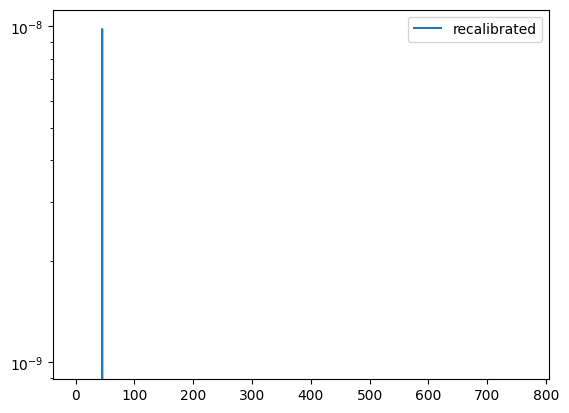

In [176]:
# plt.plot(old_cl[1:], label='old')
plt.plot(C_hi_2[45,45,:], label='recalibrated')
# plt.plot(Cl_hi[45,1:], label='HI')
# plt.plot(cov[1:,53,53], label='from glass')
# plt.plot(cls_full[45,45,1:], label='full')
plt.yscale('log')
plt.legend()

In [68]:
map=np.zeros_like(old_maps)
for i in range(nfreqs-1):
    map[i,:]=hp.synfast(C_hi_2[i,:], nside=nside, lmax=lmax)


In [50]:
np.save('recal_hi_maps.npy', map)

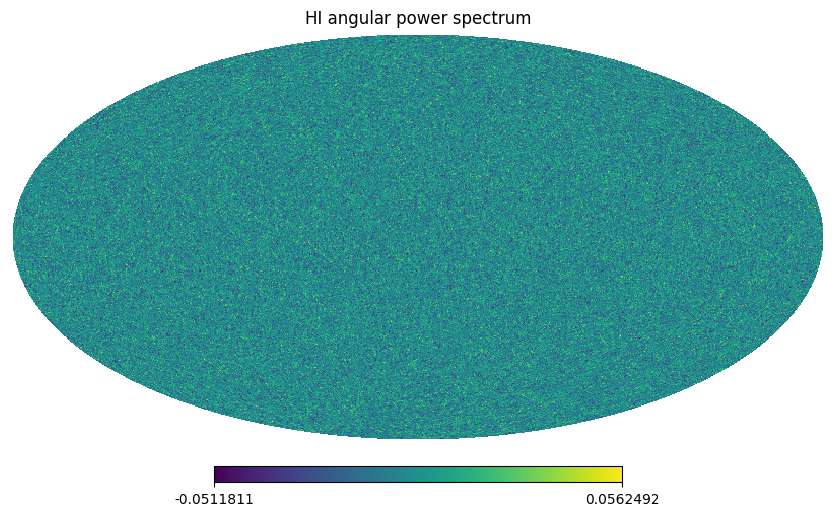

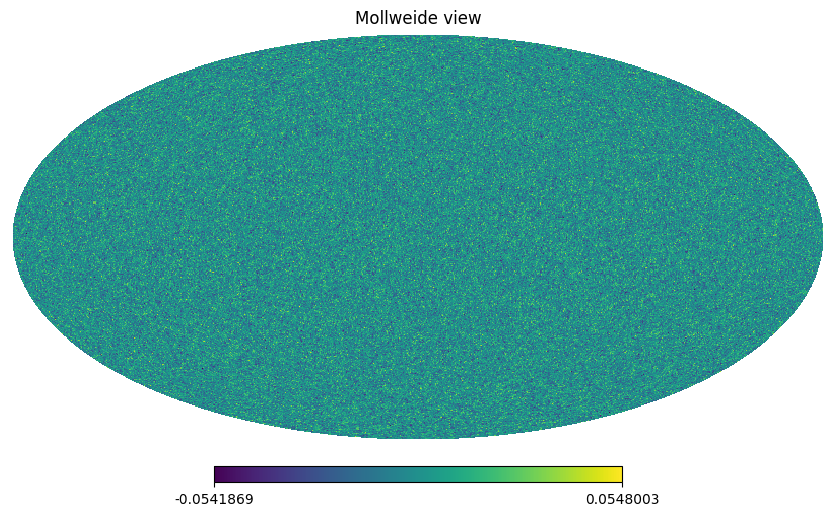

In [69]:
hp.mollview(map[45], title='HI angular power spectrum')
hp.mollview(old_cal[45])